In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


import numpy as np

import random
import math
import time
import pandas as pd
import scipy.io


In [4]:
import scipy.io
data1 = scipy.io.loadmat('data/user1-100.mat')
data2 = scipy.io.loadmat('data/user101-150.mat')
data3 = scipy.io.loadmat('data/user151-200.mat')
tariff = scipy.io.loadmat('data/Tariff2(1).mat')["Tariff"][0].tolist()
ZP = data1["ZP"].sum(axis=1) + data2["ZP"].sum(axis=1) + data3["ZP"].sum(axis=1)
ZP1 = np.concatenate((data1["ZP"], data2["ZP"][:, 100:], data3["ZP"][:, 150:]), axis=1).T
ZT = np.concatenate((data1["ZTtank"], data2["ZTtank"][:, 100:], data3["ZTtank"][:, 150:]), axis=1).T
pattern = pd.read_csv('data/0519 2000userpattern.csv')
pattern200 = np.array(pattern)[:200, 1:]

In [5]:
df = pd.read_csv('data/0728 200user.csv')

In [6]:
df.head()

,p_norm,p_flex,ls,tariff,ls_move
0,296.10,303.90,1,0.288,0.0
1,274.66,325.34,1,0.288,1.0
2,311.65,288.35,1,0.288,1.0
3,314.81,285.19,1,0.288,1.0
4,304.68,0.00,1,0.288,1.0


In [7]:
#生成测试数据
test=df[['p_norm','tariff']]
scaler = MinMaxScaler(feature_range=(0, 1))
x_test=scaler.fit_transform(test[96*243-96*2:96*243-96*1])
real_test=df[['p_norm']][96*243-96*1:]

In [8]:
#生成up和down不同的96组信号

down = []
for i in range(96):
    row = []
    for j in range(96):
        if j < i:
            row.append(0)
        else:
            row.append(-1)
    down.append(row)
down = np.array(down)

up = []
for i in range(96):
    row = []
    for j in range(96):
        if j < i:
            row.append(0)
        else:
            row.append(1)
    up.append(row)
up = np.array(up)

In [10]:
def flexoneday(p_base, t_base, dr_sig, userpattern):
    p_flex = np.zeros(96 , dtype=int)
    for i in range(200):
        flex = np.zeros(96, dtype=int).tolist()
        temp = t_base[i]
        p = p_base[i]
        pattern = userpattern[i]
        for j in range(96 - 1):
            if dr_sig[j] == 0:
                flex[j] = 0
            elif dr_sig[j] == -1:
                flex[j] = p[j]
                p[j] = 0
                if pattern[j] == 1 or pattern[j] == 2 or pattern[j] == 5:
                    temp[j + 1] = temp[j] - 1.142
                elif pattern[j] == 3:
                    temp[j + 1] = temp[j] - 8.14
                else:
                    temp[j + 1] = temp[j] - 15.143
                if temp[j] <= 60:
                    flex[j] = 0  # 温控信号与dr信号对冲，此后灵活度均降为零
            else:  # 正1信号代表此刻功率变为最大功率
                flex[j] = 3 - p[j]
                p[j] = 3
                if pattern[j] == 1 or pattern[j] == 2 or pattern[j] == 5:
                    temp[j + 1] = temp[j] + 6.4
                elif pattern[j] == 3:
                    temp[j + 1] = temp[j] - 4.6
                else:
                    temp[j + 1] = temp[j] - 8.6
                if temp[j] >= 100:
                    flex[j] = 0  # 温控信号与dr信号对冲，灵活度降为零
        p_flex = p_flex + np.array(flex)
    return p_flex


In [11]:
real_flex_up = []
for i in range(96):
    p=ZP1[:,243*96-96:].copy()# 这一步很关键，否则函数会直接对ZP1进行修改，无法循环
    t=ZT[:,243*96-96:].copy()# 同上
    a=up[i]
    flex = flexoneday(p, t , a, pattern200[:,243*96-96:]).tolist()
    real_flex_up.append(flex)

In [12]:
real_flex_down = []
for i in range(96):
    p=ZP1[:,243*96-96:].copy()
    t=ZT[:,243*96-96:].copy()
    a=down[i]
    flex = flexoneday(p, t , a, pattern200[:,243*96-96:]).tolist()
    real_flex_down.append(flex)

In [13]:
#根据倒数第二天数据进行序列预测
#对信号归一化
scaled_down = np.where(down==0,0.5,0)
scaled_up = np.where(up==0,0.5,1)
test_up =[]
for i in range(96):
    a=np.hstack((np.array(scaled_up[i]).reshape(96,1),x_test))
    test_up.append(a)
test_up = np.array(test_up)
test_down =[]
for i in range(96):
    a=np.hstack((np.array(scaled_down[i]).reshape(96,1),x_test))
    test_down.append(a)
test_down = np.array(test_down)

In [14]:
from keras.models import load_model
model = load_model('0730 GRU.h5')

F:\anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [15]:
real_up=pd.DataFrame(real_flex_up).T

In [16]:
pre_flex_up=[]
for i in range(96):
    a = test_up[i].reshape(1,96,3)
    pre_flex = model.predict(a)
    scaler.fit_transform(df['p_flex'].values.reshape(-1,1))
    pre_flex = scaler.inverse_transform(pre_flex.reshape(1,96))
    pre_flex_up.append(pre_flex)
pre_flex_up = np.array(pre_flex_up)


In [17]:
real_down=pd.DataFrame(real_flex_down).T
pre_flex_down=[]
for i in range(96):
    a = test_down[i].reshape(1,96,3)
    pre_flex = model.predict(a)
    scaler.fit_transform(df['p_flex'].values.reshape(-1,1))
    pre_flex = scaler.inverse_transform(pre_flex.reshape(1,96))
    pre_flex_down.append(pre_flex)
pre_flex_down = np.array(pre_flex_down)


In [18]:
#生成灵活度表征函数
#上备用
real_up_1step=[]
for i in range(96):
    a=real_flex_up[i][i]
    real_up_1step.append(a)
real_up_1step=np.array(real_up_1step)

real_up_2step=[]
for i in range(48):
    a=[real_flex_up[i][i],real_flex_up[i][i+1]]
    b=np.min(a)
    real_up_2step.append(b)
    real_up_2step.append(b)
real_up_2step=np.array(real_up_2step)

real_up_4step=[]
for i in range(24):
    a=[real_flex_up[i][i],real_flex_up[i][i+1],real_flex_up[i][i+2],real_flex_up[i][i+3]]
    b=np.min(a)
    real_up_4step.append(b)
    real_up_4step.append(b)
    real_up_4step.append(b)
    real_up_4step.append(b)
real_up_4step=np.array(real_up_4step)
 



In [19]:
pre_flex_up=pre_flex_up.reshape(96,96)
pre_flex_down=pre_flex_down.reshape(96,96)

In [20]:
pre_up_1step=[]
for i in range(96):
    a=pre_flex_up[i][i]
    pre_up_1step.append(a)
pre_up_1step=np.array(pre_up_1step)

pre_up_2step=[]
for i in range(48):
    a=[pre_flex_up[i][i],pre_flex_up[i][i+1]]
    b=np.min(a)
    pre_up_2step.append(b)
    pre_up_2step.append(b)
pre_up_2step=np.array(pre_up_2step)

pre_up_4step=[]
for i in range(24):
    a=[pre_flex_up[i][i],pre_flex_up[i][i+1],pre_flex_up[i][i+2],pre_flex_up[i][i+3]]
    b=np.min(a)
    pre_up_4step.append(b)
    pre_up_4step.append(b)
    pre_up_4step.append(b)
    pre_up_4step.append(b)
pre_up_4step=np.array(pre_up_4step)
 



In [21]:
#下备用
real_down_1step=[]
for i in range(96):
    a=real_flex_down[i][i]
    real_down_1step.append(a)
real_down_1step=np.array(real_down_1step)

real_down_2step=[]
for i in range(48):
    a=[real_flex_down[i][i],real_flex_down[i][i+1]]
    b=np.min(a)
    real_down_2step.append(b)
    real_down_2step.append(b)
real_down_2step=np.array(real_down_2step)

real_down_4step=[]
for i in range(24):
    a=[real_flex_down[i][i],real_flex_down[i][i+1],real_flex_down[i][i+2],real_flex_down[i][i+3]]
    b=np.min(a)
    real_down_4step.append(b)
    real_down_4step.append(b)
    real_down_4step.append(b)
    real_down_4step.append(b)
real_down_4step=np.array(real_down_4step)
 




In [22]:
pre_down_1step=[]
for i in range(96):
    a=pre_flex_down[i][i]
    pre_down_1step.append(a)
pre_down_1step=np.array(pre_down_1step)

pre_down_2step=[]
for i in range(48):
    a=[pre_flex_down[i][i],pre_flex_down[i][i+1]]
    b=np.min(a)
    pre_down_2step.append(b)
    pre_down_2step.append(b)
pre_down_2step=np.array(pre_down_2step)

pre_down_4step=[]
for i in range(24):
    a=[pre_flex_down[i][i],pre_flex_down[i][i+1],pre_flex_down[i][i+2],pre_flex_down[i][i+3]]
    b=np.min(a)
    pre_down_4step.append(b)
    pre_down_4step.append(b)
    pre_down_4step.append(b)
    pre_down_4step.append(b)
pre_down_4step=np.array(pre_down_4step)
 



In [23]:
pre_up_1step.shape

(96,)

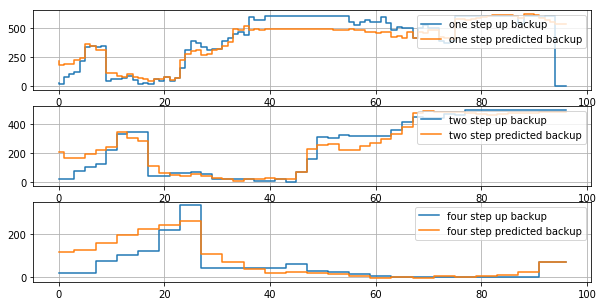

In [24]:
#画图
plt.figure(figsize=(10,5))
ax1 = plt.subplot(311)
x1=np.linspace(0,96,96).astype(int)
l1=plt.step(x1,real_up_1step,label='one step up backup')
l2=plt.step(x1,pre_up_1step,label='one step predicted backup')
plt.legend(loc = 'upper right')
# plt.yticks(y)
plt.grid()

ax2 = plt.subplot(312)
l1=plt.step(x1,real_up_2step,label='two step up backup')
l2=plt.step(x1,pre_up_2step,label='two step predicted backup')
plt.legend(loc = 'upper right')
# plt.yticks(y)
plt.grid()

ax3 = plt.subplot(313)
l1=plt.step(x1,real_up_4step,label='four step up backup')
l2=plt.step(x1,pre_up_4step,label='four step predicted backup')
plt.legend(loc = 'upper right')
# plt.yticks(y)
plt.grid()



plt.show()

